# Time Series End-to-End Exercise
***

### Earth Surface Temperature Analysis

- You will use the earth surface temperature data offered by Berkeley Earth through Kaggle.com. 
- You will select one location, could be a city or a state or something relatively similar in size and analyze the patterns in temperature over time. 
- You will then model those patterns to forecast temperature into the future (how far is up to you, but should be something meaningful).

# Acquire

#### We will obtain data from this kaggle competition:
https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt


In [2]:
#Read local .csv downloaded from kaggle.com and store data in a dataframe
df = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


# Prepare & Explore

In [3]:
#Look at data to see what preparation and cleaning needs to be done
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 0 to 239176
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             239177 non-null  object 
 1   AverageTemperature             228175 non-null  float64
 2   AverageTemperatureUncertainty  228175 non-null  float64
 3   City                           239177 non-null  object 
 4   Country                        239177 non-null  object 
 5   Latitude                       239177 non-null  object 
 6   Longitude                      239177 non-null  object 
dtypes: float64(2), object(5)
memory usage: 12.8+ MB


In [4]:
#Looking for nulls
df.isna().sum()

dt                                   0
AverageTemperature               11002
AverageTemperatureUncertainty    11002
City                                 0
Country                              0
Latitude                             0
Longitude                            0
dtype: int64

In [5]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [6]:
df.shape

(239177, 7)

In [7]:
df[df.AverageTemperature.isna() == True]

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
36,1852-01-01,NaN,NaN,Abidjan,Côte D'Ivoire,5.63N,3.23W
37,1852-02-01,NaN,NaN,Abidjan,Côte D'Ivoire,5.63N,3.23W
38,1852-03-01,NaN,NaN,Abidjan,Côte D'Ivoire,5.63N,3.23W
39,1852-04-01,NaN,NaN,Abidjan,Côte D'Ivoire,5.63N,3.23W
40,1852-05-01,NaN,NaN,Abidjan,Côte D'Ivoire,5.63N,3.23W
...,...,...,...,...,...,...,...
237089,1839-10-01,NaN,NaN,Xian,China,34.56N,108.97E
237090,1839-11-01,NaN,NaN,Xian,China,34.56N,108.97E
237091,1839-12-01,NaN,NaN,Xian,China,34.56N,108.97E
237422,1867-07-01,NaN,NaN,Xian,China,34.56N,108.97E


In [8]:
df.AverageTemperature.min(), df.AverageTemperature.max()

(-26.772, 38.283)

In [9]:
df.dt.min(), df.dt.max()

('1743-11-01', '2013-09-01')

In [10]:
df['City'][(df.AverageTemperature.isna() == True)&(df.City == 'Mexico') ].value_counts()

Series([], Name: City, dtype: int64)

In [11]:
df['City'][(df.City == 'Mexico')].value_counts()

Mexico    2145
Name: City, dtype: int64

In [12]:
ds=df.groupby('City').agg({'AverageTemperature': lambda x: x.isnull().sum()})
type(ds)

pandas.core.frame.DataFrame

In [13]:
ds.sort_values(by=['AverageTemperature'])

,AverageTemperature
City,
Mexico,0.0
Los Angeles,0.0
Harbin,1.0
Wuhan,1.0
Izmir,1.0
...,...
Karachi,289.0
Fortaleza,366.0
Dar Es Salaam,379.0


In [14]:
#Choosing Mexico as the city to analyze since it has no null values and has more data than L.A.
# remove data that is not Mexico
df = df[df.City == 'Mexico']

df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
147847,1835-01-01,13.086,1.942,Mexico,Mexico,20.09N,98.96W
147848,1835-02-01,12.322,2.020,Mexico,Mexico,20.09N,98.96W
147849,1835-03-01,13.874,2.271,Mexico,Mexico,20.09N,98.96W
147850,1835-04-01,16.312,2.247,Mexico,Mexico,20.09N,98.96W
147851,1835-05-01,16.851,1.893,Mexico,Mexico,20.09N,98.96W


In [15]:
df.shape

(2145, 7)

<AxesSubplot:>

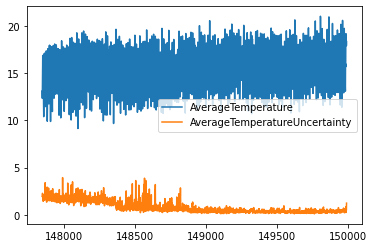

In [16]:
df.plot()

In [17]:
#Function to prepare data by creating a dataframe with temperature summed up by day

def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.dt)).sort_values('ds').\
            groupby(['ds'])[['AverageTemperature']].sum()

In [18]:
df = prep_data(df)

In [19]:
df.head()

,AverageTemperature
ds,
1835-01-01,13.086
1835-02-01,12.322
1835-03-01,13.874
1835-04-01,16.312
1835-05-01,16.851


### Split the data to use for exploration and modeling

In [20]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

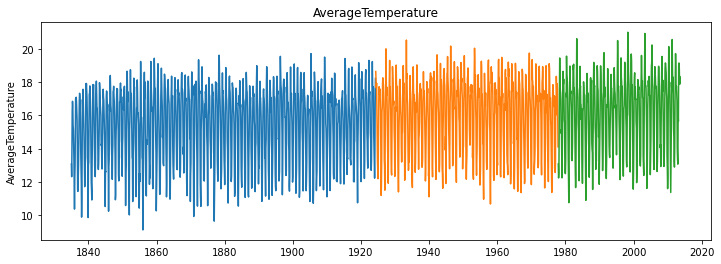

In [21]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [22]:
#Verify splits
# sum of train, validate and test = total number of rows? 
len(train) + len(validate) + len(test) == len(df)

True

## Model



### Functions for evaluation : Define functions to aid in evaluating and plotting

In [23]:
# define evaluation function to compute rmse

def evaluate(target_var):
    '''
    the evaluate function will take in the actual values in validate and the predicted values
    and compute the mean_squared_error and then take the square root and round to 0 decimals.
    It will return the rmse, an integer.
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])),0)
    return rmse

In [24]:
# plot and evaluate 

def plot_and_eval(target_var):
    '''
    this function will plot the train, validate, and test values for a single variable 
    across all dates. 
    '''

    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [25]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])

In [26]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    '''
    this function is going to take in the model_type as a string, the target variable as a string,
    and run the evaluate() function to compute the rmse, and append to the data frame a row
    with the model_type, target_var, and rmse.  It will return the new dataframe.
    '''
    rmse = evaluate(target_var)

    d = {'model_type': [model_type], 'target_var': [target_var],'rmse':[rmse]}
    d = pd.DataFrame(d)
    
    return eval_df.append(d, ignore_index=True)
    

## Forecast

#### Last Observed Value Model

In [27]:
# create var 'items' with last observed value
#items = train['items_sold'][-1][0] 

dt = train['AverageTemperature'][-1]
dt

18.226

In [28]:
# make predictions by adding those values to new dataframe yhat_df
yhat_df = pd.DataFrame({'AverageTemperature':[dt]}, index = validate.index)

yhat_df.head(2)

,AverageTemperature
ds,
1924-05-01,18.226
1924-06-01,18.226


AverageTemperature -- RMSE: 3


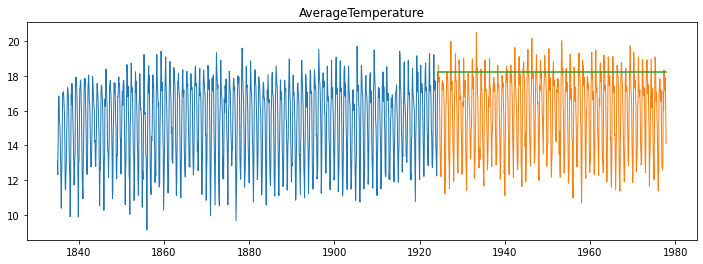

In [29]:
plot_and_eval('AverageTemperature')

In [30]:
#Evaluate
eval_df = append_eval_df(model_type = 'last_observed_value', target_var = 'AverageTemperature')

In [31]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,3.0


#### Simple Average

In [32]:
#Simple Average
at = train['AverageTemperature'].mean()
yhat_df = pd.DataFrame({'AverageTemperature':[at]}, index = validate.index)
yhat_df

,AverageTemperature
ds,
1924-05-01,15.36991
1924-06-01,15.36991
1924-07-01,15.36991
1924-08-01,15.36991
1924-09-01,15.36991
...,...
1977-07-01,15.36991
1977-08-01,15.36991
1977-09-01,15.36991


AverageTemperature -- RMSE: 2


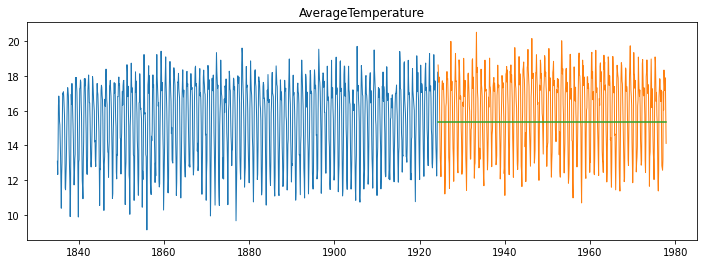

In [33]:
plot_and_eval('AverageTemperature')

In [34]:
eval_df = append_eval_df(model_type = 'simple_average', target_var = 'AverageTemperature')
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,3.0
1,simple_average,AverageTemperature,2.0


### Moving Average

In [35]:
def make_predictions():
    yhat_df = pd.DataFrame({'AverageTemperature': [AverageTemperature]}
                           , index = validate.index)
    return yhat_df

In [36]:
period = 24
#use the rolling method, take the rolling mean of 24 months, and select the last value, 
#i.e. the last day in train
dt = round(train['AverageTemperature'].rolling(period).mean().iloc[-1], 5)
yhat_df = pd.DataFrame({'AverageTemperature':[dt]}, index = validate.index)
yhat_df

,AverageTemperature
ds,
1924-05-01,15.88504
1924-06-01,15.88504
1924-07-01,15.88504
1924-08-01,15.88504
1924-09-01,15.88504
...,...
1977-07-01,15.88504
1977-08-01,15.88504
1977-09-01,15.88504


AverageTemperature -- RMSE: 2


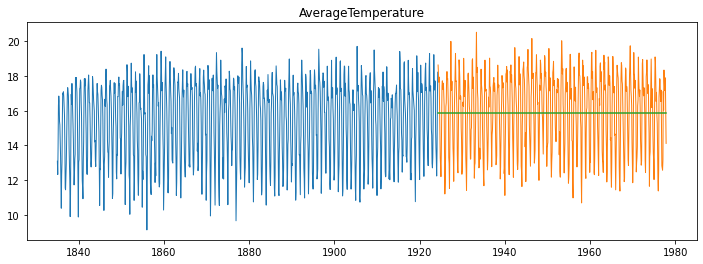

In [37]:
plot_and_eval('AverageTemperature')

In [38]:
eval_df = append_eval_df(model_type = '24month moving average', target_var = 'AverageTemperature')
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,3.0
1,simple_average,AverageTemperature,2.0
2,24month moving average,AverageTemperature,2.0


In [39]:
periods = [60, 90, 120, 150, 180, 365]

for p in periods:
    
    at = round(train['AverageTemperature'].rolling(period).mean().iloc[-1], 5)
    yhat_df = pd.DataFrame({'AverageTemperature':[at]}, index = validate.index)
    model_type = str(p) + ' Month moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'AverageTemperature')   

In [40]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,3.0
1,simple_average,AverageTemperature,2.0
2,24month moving average,AverageTemperature,2.0
3,60 Month moving average,AverageTemperature,2.0
4,90 Month moving average,AverageTemperature,2.0
5,120 Month moving average,AverageTemperature,2.0
6,150 Month moving average,AverageTemperature,2.0
7,180 Month moving average,AverageTemperature,2.0
8,365 Month moving average,AverageTemperature,2.0


### Holt's Linear Trend

AverageTemperature 



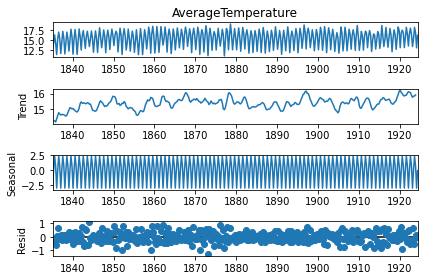

In [41]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('3M').mean()).plot()
    plt.show()

AverageTemperature 



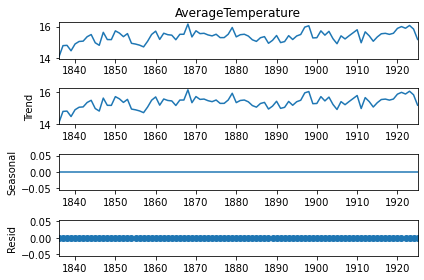

In [42]:
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('Y').mean()).plot()
    plt.show()

In [43]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [44]:
yhat_df.head(3)

,AverageTemperature
ds,
1924-05-01,15.49
1924-06-01,15.46
1924-07-01,15.43


AverageTemperature -- RMSE: 12


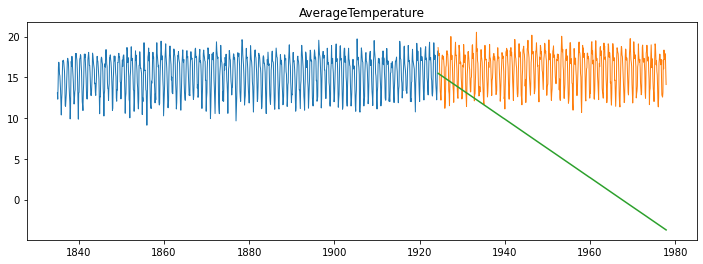

In [45]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [46]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

In [47]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,3.0
1,simple_average,AverageTemperature,2.0
2,24month moving average,AverageTemperature,2.0
3,60 Month moving average,AverageTemperature,2.0
4,90 Month moving average,AverageTemperature,2.0
5,120 Month moving average,AverageTemperature,2.0
6,150 Month moving average,AverageTemperature,2.0
7,180 Month moving average,AverageTemperature,2.0
8,365 Month moving average,AverageTemperature,2.0
9,Holts,AverageTemperature,12.0


### Predict on Previous Cycle

In [67]:
train = df[:'1954']
validate = df['1955':'1985']
test = df['1986':'2012']

In [49]:
#Make predictions using average year over year differences for next 30 years.
# Adding that average delta to the values during 1924-1954. 
yhat_df = train['1924':'1954'] + train.diff(30*12).mean()

In [50]:
pd.concat([yhat_df.head(1), validate.head(1)])

,AverageTemperature
ds,
1924-01-01,12.520006
1955-01-01,12.164000


In [51]:
#Set yhat_df to index of validate:
#Setting the index in your yhat dataframe to represent the dates those predictions are made for
yhat_df.index = validate.index

len(yhat_df)

372

AverageTemperature -- RMSE: 1


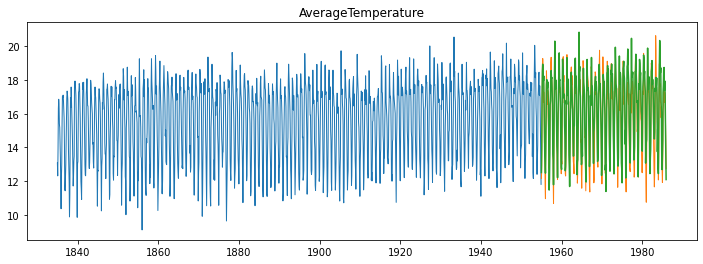

In [52]:
plot_and_eval('AverageTemperature')

In [53]:
eval_df = append_eval_df(model_type = 'previous cycle', target_var = 'AverageTemperature')

### Comparing and Selecting Best Model

In [54]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,3.0
1,simple_average,AverageTemperature,2.0
2,24month moving average,AverageTemperature,2.0
3,60 Month moving average,AverageTemperature,2.0
4,90 Month moving average,AverageTemperature,2.0
5,120 Month moving average,AverageTemperature,2.0
6,150 Month moving average,AverageTemperature,2.0
7,180 Month moving average,AverageTemperature,2.0
8,365 Month moving average,AverageTemperature,2.0
9,Holts,AverageTemperature,12.0


In [55]:
#Which model performed best
# get the min rmse for each variable

min_rmse_amount = eval_df.groupby('target_var')['rmse'].min()[0]


# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[(eval_df.rmse == min_rmse_amount) ]

,model_type,target_var,rmse
10,previous cycle,AverageTemperature,1.0


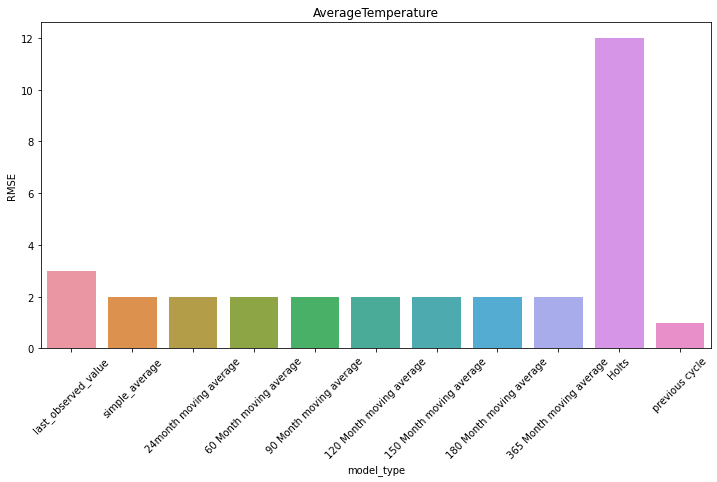

In [56]:
#Plot model comparison
x = eval_df[eval_df.target_var == 'AverageTemperature']['model_type']
y = eval_df[eval_df.target_var == 'AverageTemperature']['rmse']
plt.figure(figsize=(12, 6))
sns.barplot(x, y)
plt.title(col)
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

#### Takeaways

- The Previous Cycle Model performed best with an RMSE of 1.0.

- Will be using that model to predict on test.
***

# Predict on Test

### Let's test our best model out on our out-of-sample data

- We will be using Previous Cycle Model to predict test.

In [68]:
#Make predictions using Previous Cycle model
yhat_df = train['1928':'1954'] + train.diff(30*12).mean()

In [69]:
yhat_df.index = test.index

In [70]:
rmse_avgtemp = round(sqrt(mean_squared_error(test['AverageTemperature'], yhat_df['AverageTemperature'])), 0)


In [73]:
print("rmse - Average Temperature: ", rmse_avgtemp)

rmse - Average Temperature:  1.0


In [74]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

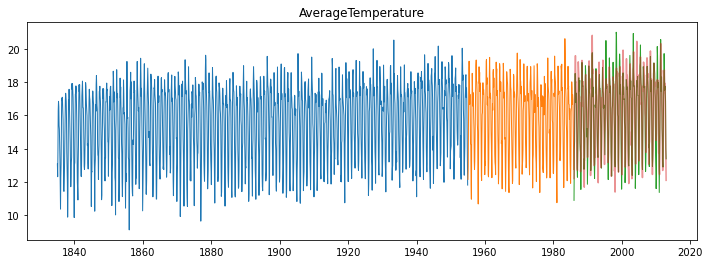

In [75]:
plot_and_eval('AverageTemperature')